<a href="https://colab.research.google.com/github/rafsanalhad/machine_learning_jobsheet/blob/main/Week12_Praktikum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from zipfile import ZipFile

file_name = "/content/data.zip"

# 3. Tambahkan pengecekan error
try:
    with ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall()
        print("Ekstraksi berhasil!")
except FileNotFoundError:
    print(f"File {file_name} tidak ditemukan. Mohon periksa nama dan lokasi file.")
except Exception as e:
    print(f"Terjadi error: {str(e)}")

Ekstraksi berhasil!


In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Create Label Variable

In [ ]:
labels = os.listdir(r"/content/data")

In [ ]:
labels
#Show label and create labels variable

['Closed', 'Open', 'yawn', 'no_yawn']

# Tampilkan random image

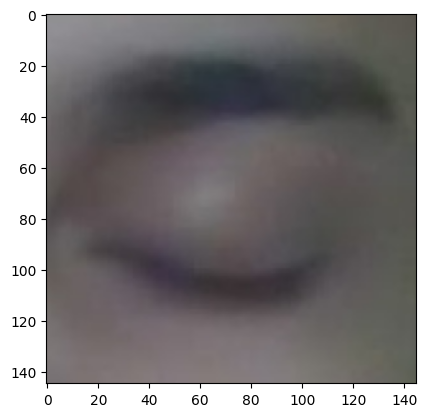

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"/content/data/Closed/_3.jpg"))

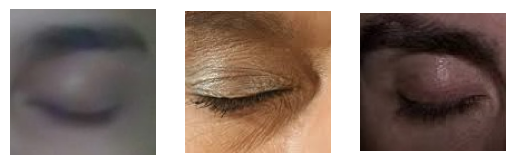

In [ ]:
# tampilkan beberapa img
image_paths = [r"/content/data/Closed/_3.jpg", r"/content/data/Closed/_10.jpg",r"/content/data/Closed/_20.jpg"]

num_images = len(image_paths)
fig, axes = plt.subplots(1, num_images)

for i, image_path in enumerate(image_paths):
    image = plt.imread(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

  ## Extract only the face region from both yawn and not_yawn images.

In [ ]:
def face_for_yawn(direc=r"/content/data", face_cas_path=r"/content/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    face_cascade = cv2.CascadeClassifier(face_cas_path)

    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            try:
                image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
                faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
                for (x, y, w, h) in faces:
                    roi_color = image_array[y:y+h, x:x+w]
                    resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                    yaw_no.append([resized_array, class_num1])
            except Exception as e:
                print(f"Error processing image {image}: {e}")

    return yaw_no

## For Closed and Open eye

In [ ]:
def get_data(dir_path=r"/content/data"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []

    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label) + 2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(f"Error processing image {img}: {e}")

    return data

## Expand the dataset by adding more data and convert the data into an array format.

In [ ]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)

    # Ensure all images and labels are correctly formatted
    images = []
    labels = []

    for item in yaw_no:
        images.append(item[0])
        labels.append(item[1])

    return np.array(images), np.array(labels)

## New variable to store

In [ ]:
new_images, new_labels = append_data()
print("Data shape:", new_images.shape, new_labels.shape)

0
1
2
3
Data shape: (1925, 145, 145, 3) (1925,)


## Separate the labels and features in the dataset

## Reshape images X

In [ ]:
X = np.array(new_images)
X = X.reshape(-1, 145, 145, 3)

In [ ]:
X.shape

(1925, 145, 145, 3)

## Perform label binarization.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(new_labels)

## Label array

In [ ]:
y = np.array(y)

In [ ]:
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

## Train Test split

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [ ]:
len(X_test)

578

## Import some dependencies

In [ ]:
from tensorflow.python.keras.layers import Lambda, Dropout
from tensorflow.python.keras.layers.advanced_activations import ELU, LeakyReLU, ReLU
from tensorflow.python.keras import activations
from keras import callbacks, layers, metrics, regularizers
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation,SimpleRNN
import cv2
import os
import numpy as np
import pandas as pd
import pickle


## Data Augmentation

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Build and train CNN model

In [ ]:
model_CNN = keras.models.Sequential()

model_CNN.add(Conv2D(filters= 256, kernel_size=(3, 3), activation="relu", input_shape=(145,145,3)))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(filters= 128, kernel_size= (3, 3), activation="relu",kernel_initializer='he_normal'))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(filters= 64, kernel_size= (3, 3), activation="relu",kernel_initializer='he_normal'))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(filters= 32, kernel_size= (3, 3), activation="relu",kernel_initializer='he_normal'))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(keras.layers.Flatten())
model_CNN.add(BatchNormalization())
model_CNN.add(Dropout(0.5))

model_CNN.add(keras.layers.Dense(64, activation="relu"))
model_CNN.add(keras.layers.Dense(4, activation="softmax"))

model_CNN.build(input_shape=(None, 145, 145, 3))
model_CNN.summary()

model_CNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 batch_normalization (Batch  (None, 143, 143, 256)     1024      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 batch_normalization_1 (Bat  (None, 69, 69, 128)       512       
 chNormalization)                                                
                                                        

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint(
    '/content/best_model_CNN.weights.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min'
)
callbacks = [mcp_save]

In [ ]:
history_CNN = model_CNN.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator), callbacks=callbacks)

Epoch 1/50
43/43 [==============================] - 57s 1s/step - loss: 0.8031 - accuracy: 0.7327 - val_loss: 1.1451 - val_accuracy: 0.5208
Epoch 2/50
43/43 [==============================] - 54s 1s/step - loss: 0.4752 - accuracy: 0.8367 - val_loss: 1.0007 - val_accuracy: 0.7197
Epoch 3/50
43/43 [==============================] - 55s 1s/step - loss: 0.3896 - accuracy: 0.8686 - val_loss: 0.8865 - val_accuracy: 0.5969
Epoch 4/50
43/43 [==============================] - 55s 1s/step - loss: 0.3664 - accuracy: 0.8641 - val_loss: 0.9953 - val_accuracy: 0.5104
Epoch 5/50
43/43 [==============================] - 55s 1s/step - loss: 0.3457 - accuracy: 0.8738 - val_loss: 0.6450 - val_accuracy: 0.6938
Epoch 6/50
43/43 [==============================] - 54s 1s/step - loss: 0.2942 - accuracy: 0.8916 - val_loss: 1.0249 - val_accuracy: 0.5969
Epoch 7/50
43/43 [==============================] - 54s 1s/step - loss: 0.2869 - accuracy: 0.8953 - val_loss: 0.9077 - val_accuracy: 0.6592
Epoch 8/50
43/43 [==

Evaluasi

In [ ]:
# Evaluasi model
test_loss, test_acc = model_CNN.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

19/19 [==============================] - 6s 294ms/step - loss: 0.0932 - accuracy: 0.9567
Test Accuracy: 95.67%


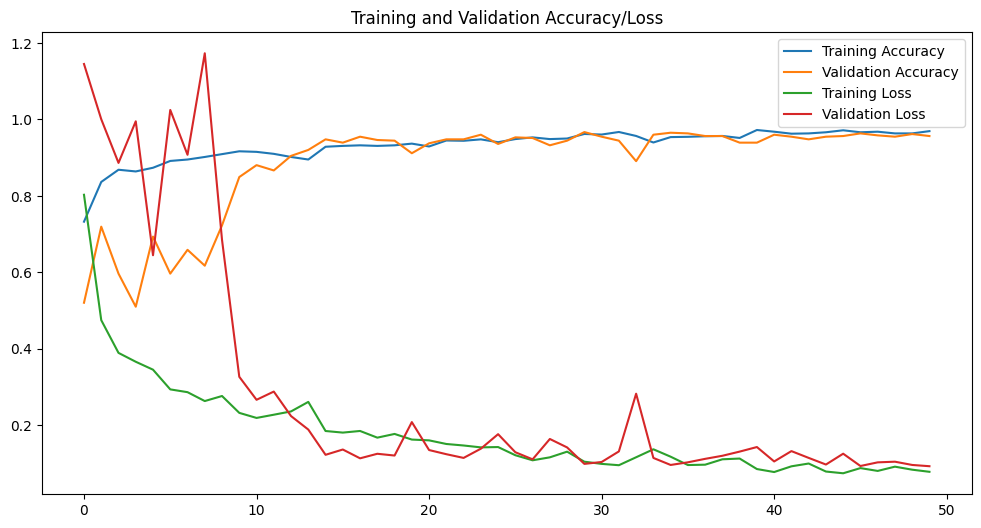

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history_CNN.history['accuracy'], label='Training Accuracy')
plt.plot(history_CNN.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_CNN.history['loss'], label='Training Loss')
plt.plot(history_CNN.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Accuracy/Loss')
plt.show()

In [ ]:
model_CNN.save('/content/history_and_model/last_model_CNN.h5')
with open('/content/history_and_model/history_CNN.pkl', 'wb') as file_pi:
    pickle.dump(history_CNN.history, file_pi)

# Build and train CNN-RNN model

In [ ]:
import keras
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, SimpleRNN, Flatten, Dropout, Dense, Reshape

model_CNN_RNN = keras.models.Sequential()

# Initial Conv2D layer to extract initial spatial features
model_CNN_RNN.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu", input_shape=(145, 145, 3)))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(MaxPooling2D(pool_size=(2, 2)))

# Another Conv2D layer before transitioning to RNN
model_CNN_RNN.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", kernel_initializer='he_normal'))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(MaxPooling2D(pool_size=(2, 2)))

# Reshape the output to be suitable for RNN input
model_CNN_RNN.add(Reshape((34, 34 * 128)))

# Adding SimpleRNN layers
model_CNN_RNN.add(SimpleRNN(64, activation='relu', return_sequences=True))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(SimpleRNN(32, activation='relu'))
model_CNN_RNN.add(BatchNormalization())

# Flatten and add Dense layers
model_CNN_RNN.add(Flatten())
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(Dropout(0.5))

model_CNN_RNN.add(Dense(64, activation="relu"))
model_CNN_RNN.add(Dense(4, activation="softmax"))

model_CNN_RNN.build(input_shape=(None, 145, 145, 3))
model_CNN_RNN.summary()

model_CNN_RNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 143, 143, 256)     7168      
                                                                 
 batch_normalization_5 (Bat  (None, 143, 143, 256)     1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 71, 71, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 batch_normalization_6 (Bat  (None, 69, 69, 128)       512       
 chNormalization)                                                
                                                      

In [ ]:
# Add Callback
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', mode='min', patience=5, verbose=1)
mcp_save = tf.keras.callbacks.ModelCheckpoint(
    '/content/history_and_model/best_model_CNN_RNN.h5', save_best_only=True, monitor='val_loss', mode='min')
callbacks = [mcp_save]

In [ ]:
history_CNN_RNN = model_CNN_RNN.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator), callbacks=callbacks)

Epoch 1/50
43/43 [==============================] - 57s 1s/step - loss: 1.4242 - accuracy: 0.3571 - val_loss: 1.1832 - val_accuracy: 0.4498
Epoch 2/50
43/43 [==============================] - 54s 1s/step - loss: 1.0849 - accuracy: 0.4989 - val_loss: 1.6008 - val_accuracy: 0.4325
Epoch 3/50
43/43 [==============================] - 54s 1s/step - loss: 0.9368 - accuracy: 0.5397 - val_loss: 2.0810 - val_accuracy: 0.3910
Epoch 4/50
43/43 [==============================] - 54s 1s/step - loss: 0.8882 - accuracy: 0.5813 - val_loss: 1.9322 - val_accuracy: 0.4827
Epoch 5/50
43/43 [==============================] - 54s 1s/step - loss: 0.8109 - accuracy: 0.6214 - val_loss: 2.1217 - val_accuracy: 0.4533
Epoch 6/50
43/43 [==============================] - 54s 1s/step - loss: 0.7157 - accuracy: 0.6837 - val_loss: 1.4588 - val_accuracy: 0.5709
Epoch 7/50
43/43 [==============================] - 54s 1s/step - loss: 0.6269 - accuracy: 0.7416 - val_loss: 2.4991 - val_accuracy: 0.4152
Epoch 8/50
43/43 [==

In [ ]:
model_CNN_RNN.save('/content/history_and_model/last_model_CNN_RNN.h5')
with open('/content/history_and_model/history_CNN_RNN.pkl', 'wb') as file_pi:
    pickle.dump(history_CNN_RNN.history, file_pi)

In [ ]:
from keras.models import load_model

best_model_CNN = load_model("/content/history_and_model/last_model_CNN.h5")
best_model_CNN_RNN = load_model("/content/history_and_model/best_model_CNN_RNN.h5")

history_path_CNN = "/content/history_and_model/history_CNN.pkl"
history_path_CNN_RNN = "/content/history_and_model/history_CNN_RNN.pkl"

with open(history_path_CNN, 'rb') as file:
    history_CNN = pickle.load(file)
with open(history_path_CNN_RNN, 'rb') as file:
    history_CNN_RNN = pickle.load(file)

## Comapare accuracy and loss on train and val set

CNN Training Accuracy:  [0.7327394485473633, 0.8366740942001343, 0.8685969114303589, 0.8641425371170044, 0.8737936019897461, 0.8916109800338745, 0.8953229188919067, 0.9020044803619385, 0.9094283580780029, 0.9168522357940674, 0.9153674840927124, 0.9101707339286804, 0.9020044803619385, 0.8953229188919067, 0.9287304878234863, 0.9309576749801636, 0.9324424862861633, 0.9309576749801636, 0.9324424862861633, 0.936896800994873, 0.9294729232788086, 0.9450631141662598, 0.9443207383155823, 0.9480326771736145, 0.9406087398529053, 0.948775053024292, 0.9532294273376465, 0.948775053024292, 0.9502598643302917, 0.9621380567550659, 0.9606533050537109, 0.9673348069190979, 0.9569413661956787, 0.9398663640022278, 0.953971803188324, 0.9547141790390015, 0.9561989903450012, 0.9569413661956787, 0.9517446160316467, 0.9725315570831299, 0.9680771827697754, 0.9628804922103882, 0.9636228680610657, 0.9665924310684204, 0.9717891812324524, 0.9665924310684204, 0.9680771827697754, 0.9636228680610657, 0.9636228680610657,

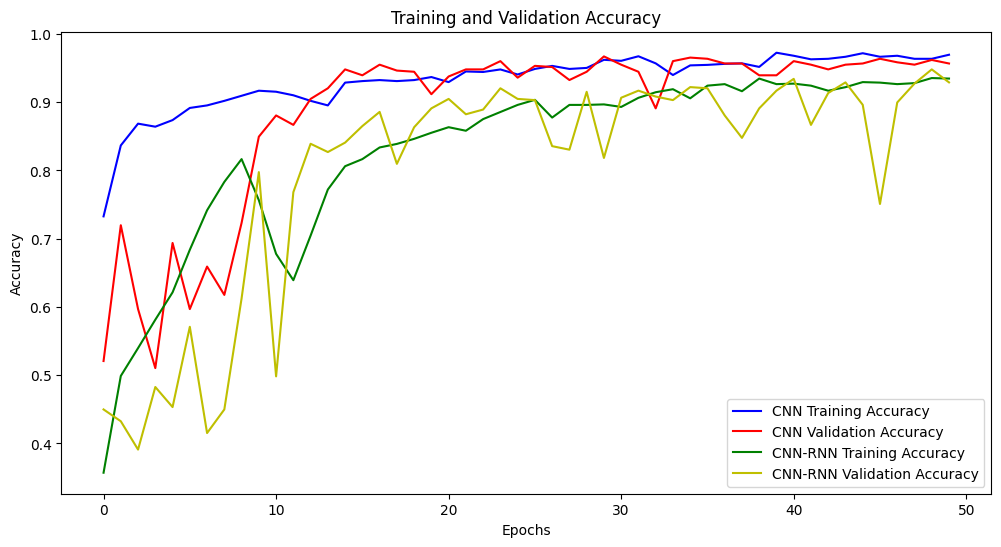

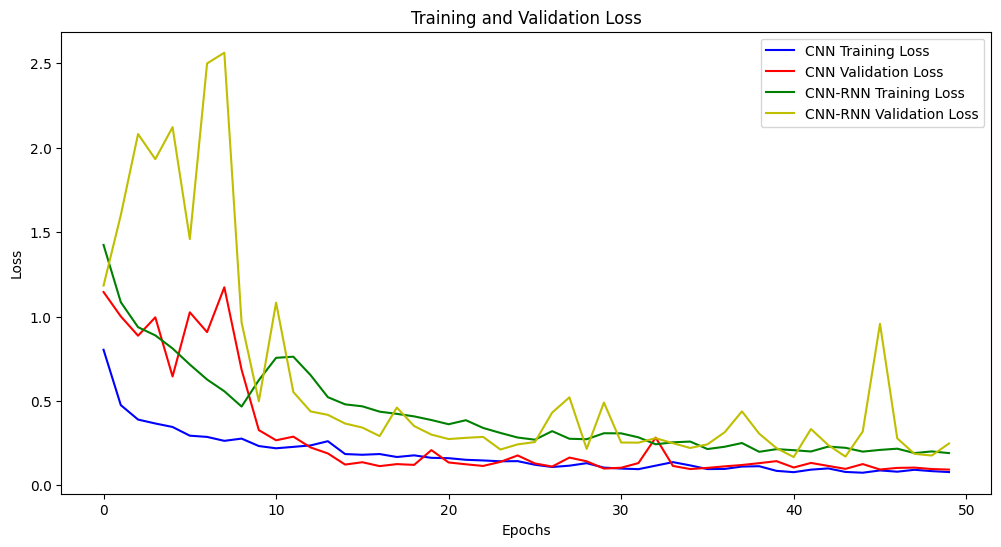

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from history
accuracy_CNN = history_CNN['accuracy']
val_accuracy_CNN = history_CNN['val_accuracy']
loss_CNN = history_CNN['loss']
val_loss_CNN = history_CNN['val_loss']

accuracy_CNN_RNN = history_CNN_RNN['accuracy']
val_accuracy_CNN_RNN = history_CNN_RNN['val_accuracy']
loss_CNN_RNN = history_CNN_RNN['loss']
val_loss_CNN_RNN = history_CNN_RNN['val_loss']

# Debug prints to verify lengths and data
print("CNN Training Accuracy: ", accuracy_CNN)
print("CNN Validation Accuracy: ", val_accuracy_CNN)
print("CNN Training Loss: ", loss_CNN)
print("CNN Validation Loss: ", val_loss_CNN)

print("CNN-RNN Training Accuracy: ", accuracy_CNN_RNN)
print("CNN-RNN Validation Accuracy: ", val_accuracy_CNN_RNN)
print("CNN-RNN Training Loss: ", loss_CNN_RNN)
print("CNN-RNN Validation Loss: ", val_loss_CNN_RNN)

epochs_CNN = list(range(len(accuracy_CNN)))
epochs_CNN_RNN = list(range(len(accuracy_CNN_RNN)))

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_CNN, accuracy_CNN, "b", label="CNN Training Accuracy")
plt.plot(epochs_CNN, val_accuracy_CNN, "r", label="CNN Validation Accuracy")
plt.plot(epochs_CNN_RNN, accuracy_CNN_RNN, "g", label="CNN-RNN Training Accuracy")
plt.plot(epochs_CNN_RNN, val_accuracy_CNN_RNN, "y", label="CNN-RNN Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_CNN, loss_CNN, "b", label="CNN Training Loss")
plt.plot(epochs_CNN, val_loss_CNN, "r", label="CNN Validation Loss")
plt.plot(epochs_CNN_RNN, loss_CNN_RNN, "g", label="CNN-RNN Training Loss")
plt.plot(epochs_CNN_RNN, val_loss_CNN_RNN, "y", label="CNN-RNN Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# classification report

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [ ]:
  # Make predictions
  predictions_CNN = best_model_CNN.predict(X_test)
  predictions_CNN_RNN = best_model_CNN_RNN.predict(X_test)

  # Convert predictions to label indices
  predicted_classes_CNN = np.argmax(predictions_CNN, axis=1)
  predicted_classes_CNN_RNN = np.argmax(predictions_CNN_RNN, axis=1)

19/19 [==============================] - 6s 303ms/step


In [ ]:
from sklearn.metrics import classification_report
# Classification report for CNN
print("Classification Report for CNN:\n")
report_CNN = classification_report(np.argmax(y_test, axis=1), predicted_classes_CNN, target_names=labels_new)
print(report_CNN)

# Classification report for CNN-RNN
print("Classification Report for CNN-RNN:\n")
report_CNN_RNN = classification_report(np.argmax(y_test, axis=1), predicted_classes_CNN_RNN, target_names=labels_new)
print(report_CNN_RNN)

Classification Report for CNN:

              precision    recall  f1-score   support

        yawn       0.00      0.00      0.00        63
     no_yawn       0.13      1.00      0.23        74
      Closed       0.00      0.00      0.00       215
        Open       0.00      0.00      0.00       226

    accuracy                           0.13       578
   macro avg       0.03      0.25      0.06       578
weighted avg       0.02      0.13      0.03       578

Classification Report for CNN-RNN:

              precision    recall  f1-score   support

        yawn       0.82      0.14      0.24        63
     no_yawn       0.71      0.16      0.26        74
      Closed       0.51      0.90      0.65       215
        Open       0.87      0.66      0.75       226

    accuracy                           0.63       578
   macro avg       0.73      0.47      0.48       578
weighted avg       0.71      0.63      0.60       578



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Confusion matrix

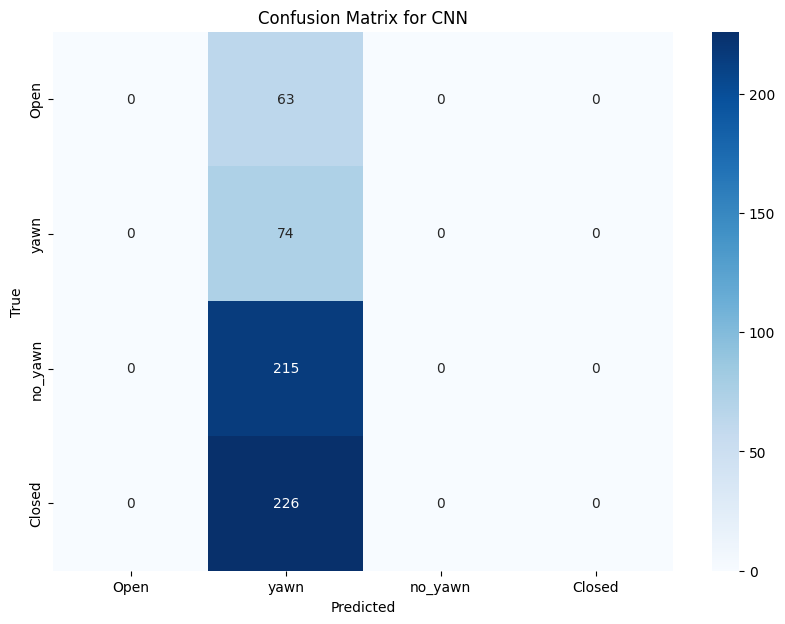

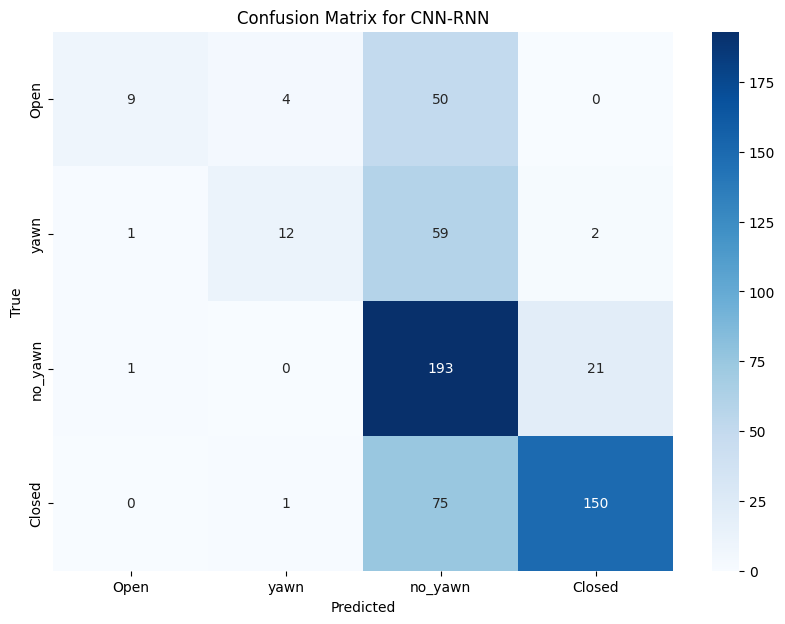

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrices
cm_CNN = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes_CNN)
cm_CNN_RNN = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes_CNN_RNN)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title, labels_new):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_new, yticklabels=labels_new)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Define class labels
labels_new = [ "Open","yawn", "no_yawn", "Closed",]

# Plot confusion matrices
plot_confusion_matrix(cm_CNN, "Confusion Matrix for CNN", labels_new)
plot_confusion_matrix(cm_CNN_RNN, "Confusion Matrix for CNN-RNN", labels_new)


# predicting function

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the model
model_CNN = load_model("/content/history_and_model/last_model_CNN_RNN.h5")

# Function to process the image and make a prediction
def predict_image(image_path):
    # Load the image using OpenCV
    img = cv2.imread(image_path)

    # Convert the image to RGB (OpenCV loads it as BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to 145x145 (the size expected by the model)
    img = cv2.resize(img, (145, 145))

    # Normalize the image (scale pixel values between 0 and 1)
    img = img / 255.0

    # Reshape the image to match the input shape expected by the model (1, 145, 145, 3)
    img = np.reshape(img, (1, 145, 145, 3))

    # Predict the class probabilities
    predictions = model_CNN.predict(img)

    # Get the predicted class (the class with the highest probability)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Map the predicted class to its label
    labels = ["Closed", "Open", "Yawn", "No Yawn"]
    predicted_label = labels[predicted_class]

    return predicted_label

# Example usage
image_path = "/content/data/yawn.jpg"  # Replace with the path to the image you want to predict
predicted_status = predict_image(image_path)
print(f"The predicted status for the image is: {predicted_status}")

1/1 [==============================] - 0s 348ms/step
The predicted status for the image is: Yawn
